# XGBoost para classificação da direção de criptos

In [32]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# Leitura dos dados
SYMBOL = 'BTCUSDT'
PERIOD = '1h'
df = pd.read_csv(f'../../data/fechamentos/{SYMBOL}_{PERIOD}_data.csv')
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

# Drop de colunas desnecessárias, quando o modelo é puxado pelo novo código
try:
    df.drop(columns=['close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], inplace=True)
except:
    pass

# Definição do target
retorno_futuro = df['close'].shift(-1) / df['close'] - 1

limiar_lucro = 0.0005

df['target'] = np.where(retorno_futuro > limiar_lucro, 1, 0) # 1 para retorno acima do limiar, 0 para abaixo

print(df['target'].value_counts(normalize=True))
print(df['target'].value_counts())


target
0    0.54634
1    0.45366
Name: proportion, dtype: float64
target
0    37875
1    31450
Name: count, dtype: int64


In [34]:
# Construção das features
def create_features(df_input): # Renomeei para df_input para evitar conflito
    df_temp = df_input.copy()
    epsilon = 1e-10

    # Retorno e Volatilidade
    df_temp['return'] = df_temp['close'].pct_change()
    df_temp['volatility_20'] = df_temp['return'].rolling(window=20).std()

    # Momentum
    df_temp['momentum_10'] = df_temp['close'].diff(10)

    # Osciladores
    def williams_r(high, low, close, period=14):
        highest_high = high.rolling(window=period).max()
        lowest_low = low.rolling(window=period).min()
        return ((highest_high - close) / (highest_high - lowest_low + epsilon)) * -100
    df_temp['williams_r_14'] = williams_r(df_temp['high'], df_temp['low'], df_temp['close'], period=14)

    def rsi(close, period=14):
        delta = close.diff()
        gain = delta.clip(lower=0).ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        loss = -delta.clip(upper=0).ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        rs = gain / (loss + epsilon)
        return 100 - (100 / (1 + rs))
    df_temp['rsi_14'] = rsi(df_temp['close'], period=14)
    df_temp['rsi_14_slope'] = df_temp['rsi_14'].diff().rolling(window=5).mean()

    # MACD
    ema_12 = df_temp['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df_temp['close'].ewm(span=26, adjust=False).mean()
    df_temp['macd'] = ema_12 - ema_26
    df_temp['macd_signal'] = df_temp['macd'].ewm(span=9, adjust=False).mean()
    df_temp['macd_hist'] = df_temp['macd'] - df_temp['macd_signal']
    df_temp['macd_slope'] = df_temp['macd'].diff().rolling(window=5).mean()

    # Bandas de Bollinger
    rolling_mean_20 = df_temp['close'].rolling(window=20).mean()
    rolling_std_20 = df_temp['close'].rolling(window=20).std()
    df_temp['bb_upper'] = rolling_mean_20 + (rolling_std_20 * 2)
    df_temp['bb_lower'] = rolling_mean_20 - (rolling_std_20 * 2)
    df_temp['bb_width'] = df_temp['bb_upper'] - df_temp['bb_lower']
    df_temp['bb_pos'] = (df_temp['close'] - df_temp['bb_lower']) / (df_temp['bb_width'] + epsilon)
    df_temp['bb_width_normalizada'] = (df_temp['bb_upper'] - df_temp['bb_lower']) / df_temp['close']

    # Volume
    price_direction = np.sign(df_temp['close'].diff()).fillna(0)
    df_temp['obv'] = (price_direction * df_temp['volume']).cumsum()
    df_temp['vol_osc'] = df_temp['volume'].rolling(5).mean() / (df_temp['volume'].rolling(20).mean() + epsilon)

    # Volatilidade (ATR)
    def atr(df_atr, window=14):
        tr_high_low = df_atr['high'] - df_atr['low']
        tr_high_prev_close = abs(df_atr['high'] - df_atr['close'].shift())
        tr_low_prev_close = abs(df_atr['low'] - df_atr['close'].shift())
        tr = pd.DataFrame({'hl': tr_high_low, 'hpc': tr_high_prev_close, 'lpc': tr_low_prev_close}).max(axis=1)
        return tr.rolling(window=window).mean()
    df_temp['atr_14'] = atr(df_temp, window=14)
    df_temp['atr_normalizado'] = df_temp['atr_14'] / df_temp['close']

    # ADX (Força da Tendência)
    def adx(df_adx, period=14):
        high = df_adx['high']
        low = df_adx['low']
        close = df_adx['close']
        
        up = high.diff()
        down = -low.diff()
        
        plus_dm = np.where((up > down) & (up > 0), up, 0)
        minus_dm = np.where((down > up) & (down > 0), down, 0)

        tr1 = high - low
        tr2 = abs(high - close.shift(1))
        tr3 = abs(low - close.shift(1))
        tr = pd.DataFrame({'tr1': tr1, 'tr2': tr2, 'tr3': tr3}).max(axis=1)
        
        atr_val = tr.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        plus_di = 100 * (pd.Series(plus_dm, index=df_adx.index).ewm(alpha=1/period, min_periods=period, adjust=False).mean() / (atr_val + epsilon))
        minus_di = 100 * (pd.Series(minus_dm, index=df_adx.index).ewm(alpha=1/period, min_periods=period, adjust=False).mean() / (atr_val + epsilon))

        dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di + epsilon))
        adx_val = dx.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        return adx_val, plus_di, minus_di
    
    df_temp['adx_14'], df_temp['pdi_14'], df_temp['ndi_14'] = adx(df_temp, period=14)
    df_temp['adx_14_slope'] = df_temp['adx_14'].diff().rolling(window=5).mean()

    # Features de Interação
    df_temp['retorno_x_vol'] = df_temp['return'] * df_temp['volatility_20']
    df_temp['retorno_x_macd'] = df_temp['return'] * df_temp['macd']
    df_temp['retorno_x_bb_pos'] = df_temp['return'] * df_temp['bb_pos']
    df_temp['vol_x_macd'] = df_temp['volatility_20'] * df_temp['macd']
    df_temp['vol_x_bb_pos'] = df_temp['volatility_20'] * df_temp['bb_pos']
    df_temp['macd_x_bb_pos'] = df_temp['macd'] * df_temp['bb_pos']
    df_temp['adx_x_pdi'] = df_temp['adx_14'] * df_temp['pdi_14']
    df_temp['adx_x_ndi'] = df_temp['adx_14'] * df_temp['ndi_14']
    df_temp['pdi_x_ndi'] = df_temp['pdi_14'] * df_temp['ndi_14']
    df_temp['adx_x_macd'] = df_temp['adx_14'] * df_temp['macd']
    df_temp['adx_x_bb_pos'] = df_temp['adx_14'] * df_temp['bb_pos']
    df_temp['pdi_x_bb_pos'] = df_temp['pdi_14'] * df_temp['bb_pos']
    df_temp['ndi_x_bb_pos'] = df_temp['ndi_14'] * df_temp['bb_pos']
    df_temp['adx_x_return'] = df_temp['adx_14'] * df_temp['return']
    df_temp['pdi_x_return'] = df_temp['pdi_14'] * df_temp['return']
    df_temp['ndi_x_return'] = df_temp['ndi_14'] * df_temp['return']    
    df_temp['macd_x_return'] = df_temp['macd'] * df_temp['return']
    df_temp['bb_pos_x_return'] = df_temp['bb_pos'] * df_temp['return']
    df_temp['obv_x_return'] = df_temp['obv'] * df_temp['return']
    df_temp['obv_x_volatility'] = df_temp['obv'] * df_temp['volatility_20']
    df_temp['obv_x_macd'] = df_temp['obv'] * df_temp['macd']
    df_temp['pdi_x_macd'] = df_temp['pdi_14'] * df_temp['macd']
    df_temp['ndi_x_macd'] = df_temp['ndi_14'] * df_temp['macd']
    df_temp['pdi_x_adx'] = df_temp['pdi_14'] * df_temp['adx_14']
    df_temp['ndi_x_adx'] = df_temp['ndi_14'] * df_temp['adx_14']
    df_temp['pdi_x_atr'] = df_temp['pdi_14'] * df_temp['atr_14']
    df_temp['ndi_x_atr'] = df_temp['ndi_14'] * df_temp['atr_14']
    df_temp['adx_x_atr'] = df_temp['adx_14'] * df_temp['atr_14']
    df_temp['return_x_atr'] = df_temp['return'] * df_temp['atr_14']
    df_temp['volatility_x_atr'] = df_temp['volatility_20'] * df_temp['atr_14']
    df_temp['obv_x_atr'] = df_temp['obv'] * df_temp['atr_14']
    df_temp['macd_x_atr'] = df_temp['macd'] * df_temp['atr_14']
    df_temp['bb_pos_x_atr'] = df_temp['bb_pos'] * df_temp['atr_14']

    # Lag Features
    lag_cols = ['return', 'volatility_20', 'macd_hist', 'bb_pos', 'retorno_x_vol', 'retorno_x_macd', 'retorno_x_bb_pos']
    for col in lag_cols:
        for lag in range(1, 4):
            df_temp[f'{col}_lag_{lag}'] = df_temp[col].shift(lag)

    df_temp.dropna(inplace=True)
    return df_temp
      
# Aplicação da função
df = create_features(df.copy()) # Aplicando create_features no df original
df = df.drop(columns=['open', 'high', 'low', 'volume'])

# Divisão dos dados entre até 2025 e a partir de 2025,
# essa divisão é um teste final de overfitting, já que o modelo performou muito bem
df_in_sample = df[df.index < '2025-01-01']
df_out_of_sample = df[df.index >= '2025-01-01']

--- INICIANDO VALIDAÇÃO E SIMULAÇÃO ENCADEADA COM 18 FOLDS ---

--- Processando Fold 1/18 ---
Benchmark 'Buy & Hold' total iniciará em 2018-01-07 com preço 16607.00
Precisão real nos sinais de compra do Fold: 49.12%
Saldo inicial do Fold: 1000.00 | Saldo Final do Fold: 904.05 | Trades: 12

--- Processando Fold 2/18 ---
Precisão real nos sinais de compra do Fold: 52.94%
Saldo inicial do Fold: 904.05 | Saldo Final do Fold: 785.41 | Trades: 54

--- Processando Fold 3/18 ---
Precisão real nos sinais de compra do Fold: 61.76%
Saldo inicial do Fold: 785.41 | Saldo Final do Fold: 748.96 | Trades: 54

--- Processando Fold 4/18 ---
Precisão real nos sinais de compra do Fold: 58.82%
Saldo inicial do Fold: 748.96 | Saldo Final do Fold: 1130.52 | Trades: 46

--- Processando Fold 5/18 ---
Precisão real nos sinais de compra do Fold: 60.29%
Saldo inicial do Fold: 1130.52 | Saldo Final do Fold: 983.87 | Trades: 56

--- Processando Fold 6/18 ---
Precisão real nos sinais de compra do Fold: 52.94%
Saldo 

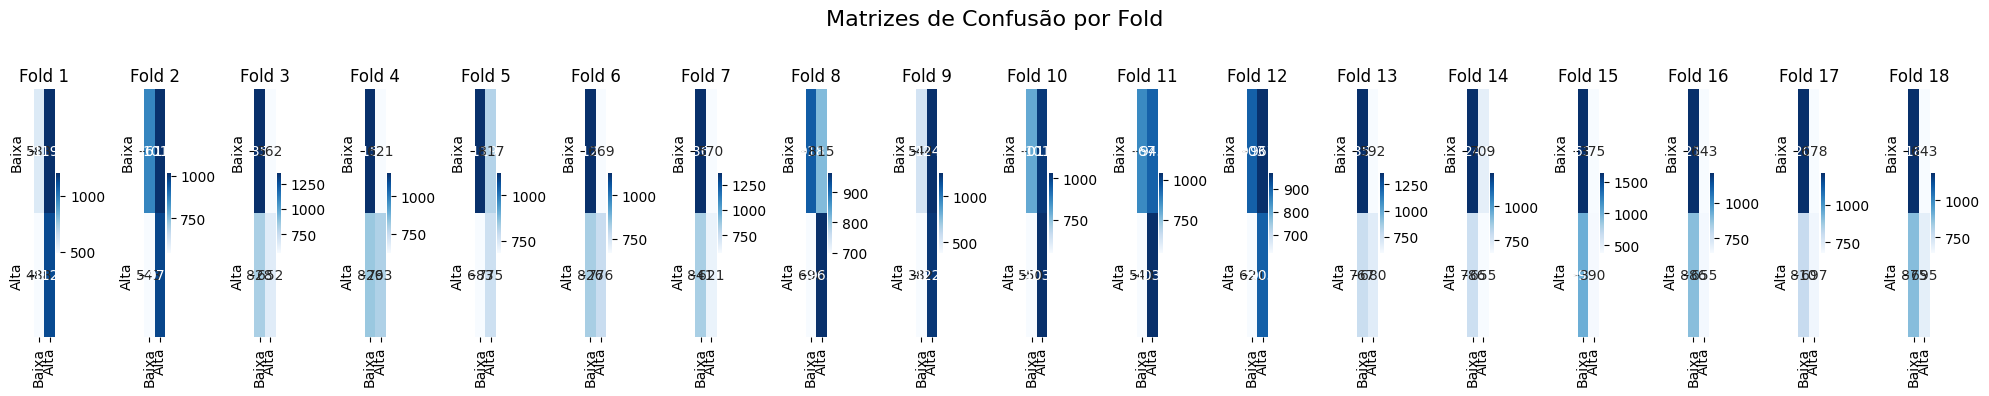


-----------------------------------
| Resumo das Métricas por Fold      |
-----------------------------------


,AUC,Acurácia,Precisão,Recall,F1 Score
Fold,,,,,
1,0.537904,0.503536,0.484718,0.697646,0.572009
2,0.572826,0.540955,0.489950,0.642292,0.555872
3,0.597507,0.590454,0.537068,0.440541,0.484039
4,0.590052,0.573659,0.560820,0.489809,0.522915
5,0.579788,0.558044,0.486809,0.531550,0.508197
6,0.575858,0.559517,0.537024,0.484395,0.509353
7,0.590142,0.584266,0.521411,0.424761,0.468149
8,0.563580,0.554213,0.541620,0.579771,0.560047
9,0.557060,0.520035,0.494733,0.761697,0.599853


Média do AUC: 0.5736
Média do Recall: 0.5272


------------------------------------------------------------
| Resumo da Performance da Simulação por Fold de Teste      |
------------------------------------------------------------
 Fold Período Início Período Fim  Saldo Inicial  Saldo Final  Retorno Estratégia (%)  Retorno Buy & Hold (%)  Retorno Líquido (%)  Nº Trades
    1     2018-01-07  2018-05-30    1000.000000   904.054052               -9.594595              -54.846631            45.252036         12
    2     2018-05-30  2018-10-19     904.054052   785.410291              -13.123525              -11.776929            -1.346597         54
    3     2018-10-19  2019-03-10     785.410291   748.962213               -4.640642              -40.434285            35.793643         54
    4     2019-03-10  2019-07-30     748.962213  1130.517031               50.944468              143.701555           -92.757087         46
    5     2019-07-30  2019-12-19    1130.517031   983.870304    

In [35]:
def simulate_trading(test_df_fold, model_fold, initial_balance_fold, fee=0.001, 
                     buy_threshold=0.6, sell_threshold=0.4, stop_loss=None):
    """
    Simula uma estratégia de trading com limiares de probabilidade e stop-loss opcional.
    """
    df_sim = test_df_fold.copy()
    
    features_to_predict = df_sim.drop('target', axis=1, errors='ignore')
    probas = model_fold.predict_proba(features_to_predict)[:, 1]
    df_sim['probas'] = probas
    
    balance = initial_balance_fold
    position = 0
    entry_price = 0
    trades = []

    for i in range(1, len(df_sim)):
        prob_buy = df_sim['probas'].iloc[i-1] 
        current_price = df_sim['close'].iloc[i]
        current_time = df_sim.index[i]

        if position > 0 and stop_loss is not None:
            stop_price_level = entry_price * (1 - stop_loss)
            if current_price <= stop_price_level:
                balance = position * current_price * (1 - fee)
                trades.append(('Stop-Loss', current_time, current_price, balance, f'SL {stop_loss*100:.1f}% hit'))
                position = 0
                entry_price = 0
                continue

        if prob_buy > buy_threshold and balance > 0:
            amount_to_spend = balance * (1 - fee)
            position = amount_to_spend / current_price
            entry_price = current_price
            trades.append(('Buy', current_time, current_price, balance, f'Prob: {prob_buy:.2f}'))
            balance = 0
        
        # Se tivermos uma posição e o modelo sinalizar venda
        elif prob_buy < sell_threshold and position > 0:
            balance = position * current_price * (1 - fee)
            trades.append(('Sell', current_time, current_price, balance, f'Prob: {prob_buy:.2f}'))
            position = 0
            entry_price = 0

    # Liquidação final se o fold terminar com uma posição aberta
    if position > 0:
        last_price = df_sim['close'].iloc[-1]
        balance = position * last_price * (1 - fee)
        trades.append(('Liquidate_Final_Fold', df_sim.index[-1], last_price, balance, 'N/A'))
        position = 0

    return trades, balance

# Configurações da Simulação
initial_balance = 1000.0
classification_threshold = 0.5

# Variáveis para armazenar resultados
results_list = []
full_simulation_trades = []
current_global_balance = initial_balance
fold_performance_list = []
overall_benchmark_start_price = None

# Validação cruzada com TimeSeriesSplit
n_splits = 18
tsv = TimeSeriesSplit(n_splits=n_splits)
X = df_in_sample.drop(columns=['target'])
y = df_in_sample['target']

fig, axes = plt.subplots(1, n_splits, figsize=(20, 4))
fig.suptitle('Matrizes de Confusão por Fold', fontsize=16)

print(f"--- INICIANDO VALIDAÇÃO E SIMULAÇÃO ENCADEADA COM {n_splits} FOLDS ---")

for fold, (train_index, test_index) in enumerate(tsv.split(X)):
    print(f"\n--- Processando Fold {fold + 1}/{n_splits} ---")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Capturar o preço de início do benchmark na primeira iteração
    if fold == 0:
        first_test_period_start_index = X_test.index[0]
        overall_benchmark_start_price = df_in_sample.loc[first_test_period_start_index, 'close']
        print(f"Benchmark 'Buy & Hold' total iniciará em {first_test_period_start_index.date()} com preço {overall_benchmark_start_price:.2f}")

    model = xgb.XGBClassifier(
        n_estimators=5000, objective='binary:logistic', learning_rate=0.001,
        max_depth=6, scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1],
        subsample=1, colsample_bytree=0.8, gamma=0.1,
        early_stopping_rounds=50, random_state=42, n_jobs=-1
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > classification_threshold).astype(int)

    fold_results = {
        'Fold': fold + 1, 'AUC': roc_auc_score(y_test, y_proba),
        'Acurácia': accuracy_score(y_test, y_pred), 'Precisão': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0), 'F1 Score': f1_score(y_test, y_pred, zero_division=0)
    }
    results_list.append(fold_results)

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[fold], xticklabels=['Baixa', 'Alta'], yticklabels=['Baixa', 'Alta'])
    axes[fold].set_title(f'Fold {fold + 1}')

    test_df_for_sim = df_in_sample.loc[X_test.index].copy()
    test_df_for_sim['target'] = y_test
    
    fold_initial_balance = current_global_balance
    buy_confidence = np.percentile(y_proba, 98)
    sell_confidence = np.percentile(y_proba, 2)

    # Filtra as previsões e os resultados reais onde o sinal foi de compra
    real_trades_signals = y_proba > buy_confidence
    actual_results = y_test[real_trades_signals]

    # Calcula a precisão apenas para esses sinais
    if len(actual_results) > 0:
        precision_folded = np.mean(actual_results) # Como y_test é 0 ou 1, a média é a precisão
        print(f"Precisão real nos sinais de compra do Fold: {precision_folded:.2%}")

    trades_fold, final_balance_fold = simulate_trading(
        test_df_for_sim, model, 
        initial_balance_fold=fold_initial_balance,
        buy_threshold=buy_confidence,
        sell_threshold=sell_confidence,
        stop_loss=0.1
    )
    
    print(f"Saldo inicial do Fold: {fold_initial_balance:.2f} | Saldo Final do Fold: {final_balance_fold:.2f} | Trades: {len(trades_fold)}")

    strategy_return_fold = ((final_balance_fold - fold_initial_balance) / fold_initial_balance) * 100 if fold_initial_balance > 0 else 0
    buy_and_hold_start_price = test_df_for_sim['close'].iloc[0]
    buy_and_hold_end_price = test_df_for_sim['close'].iloc[-1]
    buy_and_hold_return_fold = ((buy_and_hold_end_price - buy_and_hold_start_price) / buy_and_hold_start_price) * 100

    fold_performance_list.append({
        "Fold": fold + 1, "Período Início": X_test.index[0].date(),
        "Período Fim": X_test.index[-1].date(), "Saldo Inicial": fold_initial_balance,
        "Saldo Final": final_balance_fold, "Retorno Estratégia (%)": strategy_return_fold,
        "Retorno Buy & Hold (%)": buy_and_hold_return_fold, "Retorno Líquido (%)": strategy_return_fold - buy_and_hold_return_fold,
        "Nº Trades": len(trades_fold)
    })
    
    current_global_balance = final_balance_fold
    full_simulation_trades.extend(trades_fold)
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- APRESENTAÇÃO DOS RESULTADOS ---

# 1. Métricas de Classificação por Fold
results_df = pd.DataFrame(results_list)
print("\n" + "-"*35)
print("| Resumo das Métricas por Fold      |")
print("-"*(35))
display(results_df.set_index('Fold'))
print(f"Média do AUC: {results_df['AUC'].mean():.4f}")
print(f"Média do Recall: {results_df['Recall'].mean():.4f}")

# 2. Performance da Estratégia por Fold
print("\n\n" + "-"*60)
print("| Resumo da Performance da Simulação por Fold de Teste      |")
print("-"*(60))
performance_by_fold_df = pd.DataFrame(fold_performance_list)
print(performance_by_fold_df.to_string(index=False))
performance_by_fold_df.to_csv(f'folds_performance_{SYMBOL}_{PERIOD}.csv', index=False)

# 3. Resumo Final da Simulação Encadeada
print("\n\n--- Resumo Final da Simulação (Total) ---")

total_return = ((current_global_balance - initial_balance) / initial_balance) * 100
overall_benchmark_end_price = df_in_sample['close'].iloc[-1]
total_return_natural = ((overall_benchmark_end_price - overall_benchmark_start_price) / overall_benchmark_start_price) * 100

print(f"Saldo Inicial Total: {initial_balance:.2f} USDT")
print(f"Saldo Final Total: {current_global_balance:.2f} USDT")
print(f"Retorno Total no Período (Estratégia): {total_return:.2f}%")
print(f"Retorno Total no Período (Buy & Hold): {total_return_natural:.2f}%")
print(f"Retorno Total Líquido (Alpha): {total_return - total_return_natural:.2f}%")
print(f"Total de Transações: {len(full_simulation_trades)}")
print("--- Fim da Simulação ---")

In [36]:
for trade in full_simulation_trades:
    print(f"{trade[0]} em {trade[1]}: Preço {trade[2]:.2f}, Saldo {trade[3]:.2f}, Observação: {trade[4]}")

Buy em 2018-01-28 08:00:00: Preço 11930.03, Saldo 1000.00, Observação: Prob: 0.50
Stop-Loss em 2018-01-30 13:00:00: Preço 10620.76, Saldo 888.47, Observação: SL 10.0% hit
Buy em 2018-02-14 15:00:00: Preço 9330.08, Saldo 888.47, Observação: Prob: 0.50
Sell em 2018-02-18 20:00:00: Preço 10765.49, Saldo 1023.11, Observação: Prob: 0.50
Buy em 2018-02-26 17:00:00: Preço 10205.00, Saldo 1023.11, Observação: Prob: 0.50
Sell em 2018-03-08 10:00:00: Preço 9993.37, Saldo 999.89, Observação: Prob: 0.50
Buy em 2018-03-14 14:00:00: Preço 8752.00, Saldo 999.89, Observação: Prob: 0.50
Stop-Loss em 2018-03-15 02:00:00: Preço 7779.98, Saldo 887.07, Observação: SL 10.0% hit
Buy em 2018-03-19 02:00:00: Preço 8156.91, Saldo 887.07, Observação: Prob: 0.50
Sell em 2018-03-27 02:00:00: Preço 7845.99, Saldo 851.55, Observação: Prob: 0.50
Buy em 2018-04-04 12:00:00: Preço 7049.00, Saldo 851.55, Observação: Prob: 0.50
Liquidate_Final_Fold em 2018-05-30 05:00:00: Preço 7498.62, Saldo 904.05, Observação: N/A
Buy 

In [37]:
# Simulação Out-of-Sample para confirmação da ausência de overfitting
test_df_for_sim = df_out_of_sample.copy()
test_df_for_sim['target'] = y_test

fold_initial_balance = current_global_balance
buy_confidence = np.percentile(y_proba, 98)
sell_confidence = np.percentile(y_proba, 2)

# Filtra as previsões e os resultados reais onde o sinal foi de compra
real_trades_signals = y_proba > buy_confidence
actual_results = y_test[real_trades_signals]

# Calcula a precisão apenas para esses sinais
if len(actual_results) > 0:
    precision_folded = np.mean(actual_results) # Como y_test é 0 ou 1, a média é a precisão
    print(f"Precisão real nos sinais de compra do Fold: {precision_folded:.2%}")

trades_fold, final_balance_fold = simulate_trading(
    df_out_of_sample, model, 
    initial_balance_fold=fold_initial_balance,
    buy_threshold=buy_confidence,
    sell_threshold=sell_confidence,
    stop_loss=0.01
)

print(f"Saldo inicial do Fold: {fold_initial_balance:.2f} | Saldo Final do Fold: {final_balance_fold:.2f} | Trades: {len(trades_fold)}")
print(f"Lucro/Prejuízo do Fold: {final_balance_fold - fold_initial_balance:.2f} USDT")
print(f"Retorno do Fold: {((final_balance_fold - fold_initial_balance) / fold_initial_balance) * 100:.2f}%")
print(f"Retorno Buy & Hold: {((df_out_of_sample['close'].iloc[-1] - df_out_of_sample['close'].iloc[0]) / df_out_of_sample['close'].iloc[0]) * 100:.2f}%")

Precisão real nos sinais de compra do Fold: 64.71%
Saldo inicial do Fold: 12837.14 | Saldo Final do Fold: 12712.79 | Trades: 128
Lucro/Prejuízo do Fold: -124.35 USDT
Retorno do Fold: -0.97%
Retorno Buy & Hold: 24.94%


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

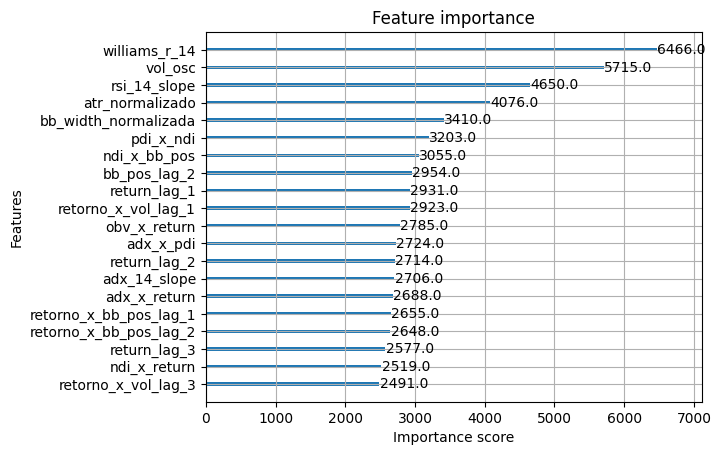

In [40]:
xgb.plot_importance(model, max_num_features=20, importance_type='weight')